# Import Packages

In [67]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

#Lecture 1: Exercise 2

Verify that $d<W, W>_t = dt$

100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


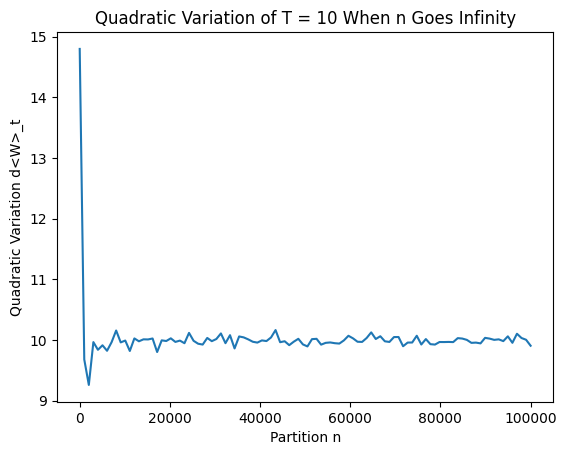

In [68]:
np.random.seed(0)
T = 10
nmax = 100000
nplot = 100
ns = np.linspace(10, nmax, nplot).astype(np.int32)
quads = np.zeros(nplot)

for i in tqdm(range(nplot)):
    Ws = np.zeros(ns[i]+1)
    dt = T/ns[i]
    for j in range(1, ns[i]+1):
      Ws[j] = Ws[j-1] + np.random.normal(0, np.sqrt(dt))
    W_ti = Ws[1:]
    W_ti_minus_1 = Ws[:-1]
    quad = np.sum((W_ti - W_ti_minus_1)**2)
    quads[i] = quad

plt.plot(ns, quads)
plt.xlabel('Partition n')
plt.ylabel('Quadratic Variation d<W>_t')
plt.title('Quadratic Variation of T = 10 When n Goes Infinity')
plt.show()

#Lecture 2: Exercise 4

In [69]:
# Black-Scholes formula for European call option
def black_scholes(S0, K, T, r, sigma, Call = True):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    sign_ = 1 if Call else -1
    price = sign_ * (S0 * norm.cdf(sign_*d1) - K * np.exp(-r * T) * norm.cdf(sign_*d2))
    delta = sign_ * norm.cdf(sign_*d1)
    gamma = norm.pdf(d1)/(S0*sigma*np.sqrt(T))
    return price, delta, gamma

# Binomial Tree
def binomial_tree(S0, K, T, r, sigma, n, Call = True, European = True):
    sign_ = 1 if Call else -1
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    p = (np.exp(r * dt) - d) / (u - d)
    df = np.exp(-r * dt)

    C = np.zeros((n+1, n+1))

    for i in range(n+1):
        C[i, n] = max(0, sign_ * (S0 * u**i * d**(n-i) - K))

    for j in range(n-1, -1, -1):
        for i in range(j+1):
            if European:
                C[i, j] = df * (p * C[i+1, j+1] + (1-p) * C[i, j+1])
            else:
                C[i, j] = np.maximum((sign_ * (S0 * u ** i * d ** (j-i) - K)),
                                     df * (p * C[i+1, j+1] + (1-p) * C[i, j+1]))
    price = C[0, 0]
    gamma = ((C[2, 2] - C[1, 2]) / (S0 * u ** 2 - S0 * u * d) - (C[1, 2] - C[0, 2]) / (S0 * u * d - S0 * d ** 2)) / (0.5 * (S0 * u ** 2 - S0 * d ** 2))
    delta = (C[1, 1] - C[0, 1]) / (S0 * u - S0 * d)
    return C[0, 0], delta, gamma

In [70]:
def plot_binomial(S0, Ks, T, r, sigma, n_steps = range(3, 301), isCall = True, isEuropean = True):
    option_type = 'Call' if isCall else 'Put'
    fig, ax = plt.subplots(len(Ks)*3, 1, figsize=(14, 10*len(Ks)*3))

    for i in range(len(Ks)):
        K = Ks[i]
        bs_price, bs_delta, bs_gamma = black_scholes(S0, K, T, r, sigma, isCall)
        bt_prices = []
        bt_deltas = []
        bt_gammas = []
        for n in tqdm(n_steps):
            bt_price, bt_delta, bt_gamma = binomial_tree(S0, K, T, r, sigma, n, isCall, isEuropean)
            bt_prices.append(bt_price)
            bt_deltas.append(bt_delta)
            bt_gammas.append(bt_gamma)

        bt = pd.DataFrame({'price': bt_prices, 'delta': bt_deltas, 'gamma': bt_gammas}, index = n_steps)
        bt_odd = bt.iloc[0::2, :]
        bt_even = bt.iloc[1::2, :]

        ax[i*3].plot(bt.index, bt['price'], label='all_n', color = 'blue')
        ax[i*3].plot(bt_odd.index, bt_odd['price'], label='odd_n', color = 'red')
        ax[i*3].plot(bt_even.index, bt_even['price'], label='even_n', color = 'green')
        l1 = ax[i*3].axhline(bs_price, color='black',ls='--')
        l1.set_label('Black-Scholes Price')
        ax[i*3].set_title(f'{option_type} Option Price at K = {K}: Binomial Tree vs Black-Scholes')
        ax[i*3].set_xlabel('Number of Steps')
        ax[i*3].set_ylabel('Price')
        ax[i*3].legend(loc = 'best')

        ax[i*3+1].plot(bt.index, bt['delta'], label='all_n', color = 'blue')
        ax[i*3+1].plot(bt_odd.index, bt_odd['delta'], label='odd_n', color = 'red')
        ax[i*3+1].plot(bt_even.index, bt_even['delta'], label='even_n', color = 'green')
        l1 = ax[i*3+1].axhline(bs_delta, color='black',ls='--')
        l1.set_label('Black-Scholes Delta')
        ax[i*3+1].set_title(f'{option_type} Option Delta at K = {K}: Binomial Tree vs Black-Scholes')
        ax[i*3+1].set_xlabel('Number of Steps')
        ax[i*3+1].set_ylabel('Price')
        ax[i*3+1].legend(loc = 'best')

        ax[i*3+2].plot(bt.index, bt['gamma'], label='all_n', color = 'blue')
        ax[i*3+2].plot(bt_odd.index, bt_odd['gamma'], label='odd_n', color = 'red')
        ax[i*3+2].plot(bt_even.index, bt_even['gamma'], label='even_n', color = 'green')
        l1 = ax[i*3+2].axhline(bs_gamma, color='black',ls='--')
        l1.set_label('Black-Scholes Gamma')
        ax[i*3+2].set_title(f'{option_type} Option Gamma at K = {K}: Binomial Tree vs Black-Scholes')
        ax[i*3+2].set_xlabel('Number of Steps')
        ax[i*3+2].set_ylabel('Price')
        ax[i*3+2].legend(loc = 'best')

    plt.tight_layout()
    plt.show()

In [71]:
S0 = 100  # Initial stock price
r = 0.0  # Risk-free rate
sigma = 0.25  # Volatility
T = 1  # Time to maturity
Ks = [90, 100, 110]  # Strike prices
n_steps = range(3, 301)  # Using steps from 1 to 300

100%|██████████| 298/298 [00:04<00:00, 62.23it/s]


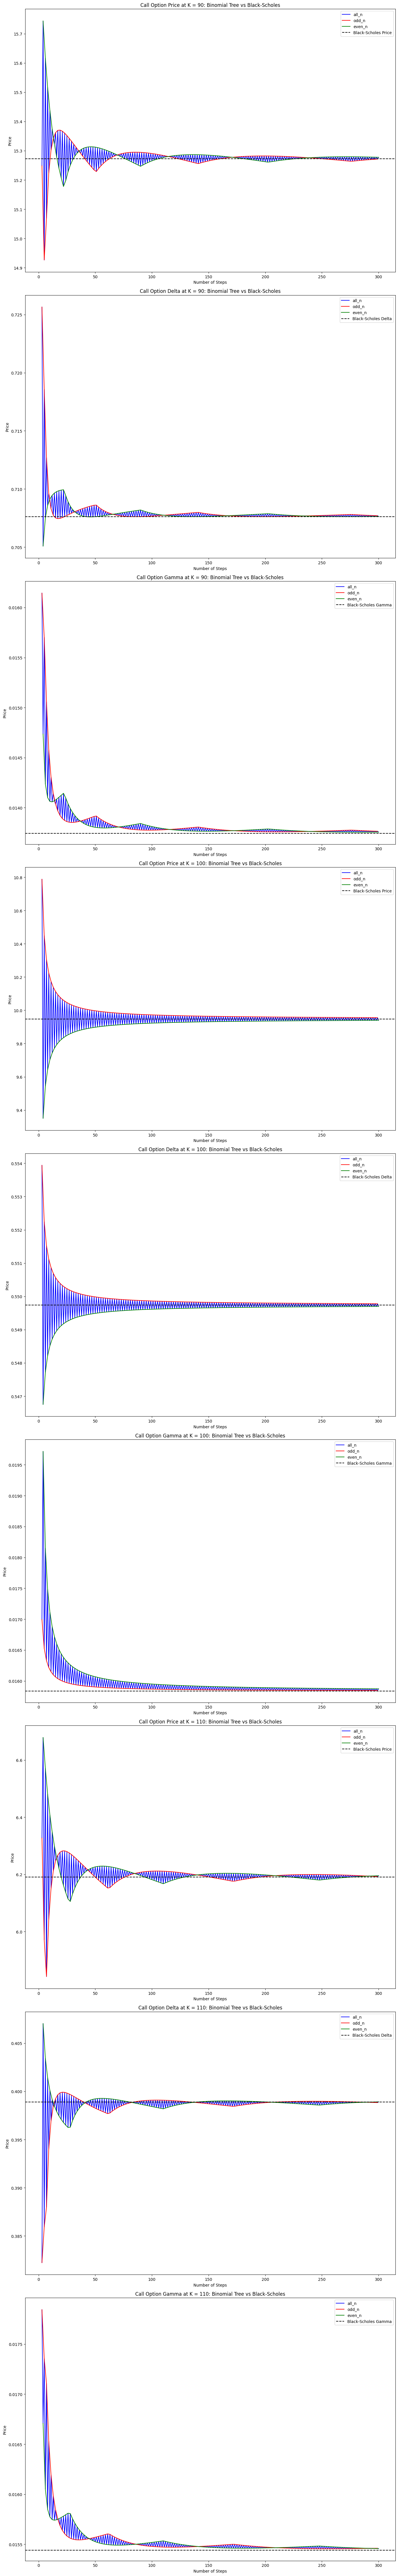

In [72]:
plot_binomial(S0, Ks, T, r, sigma, n_steps, True, True) # Call Option

100%|██████████| 298/298 [00:04<00:00, 66.47it/s]


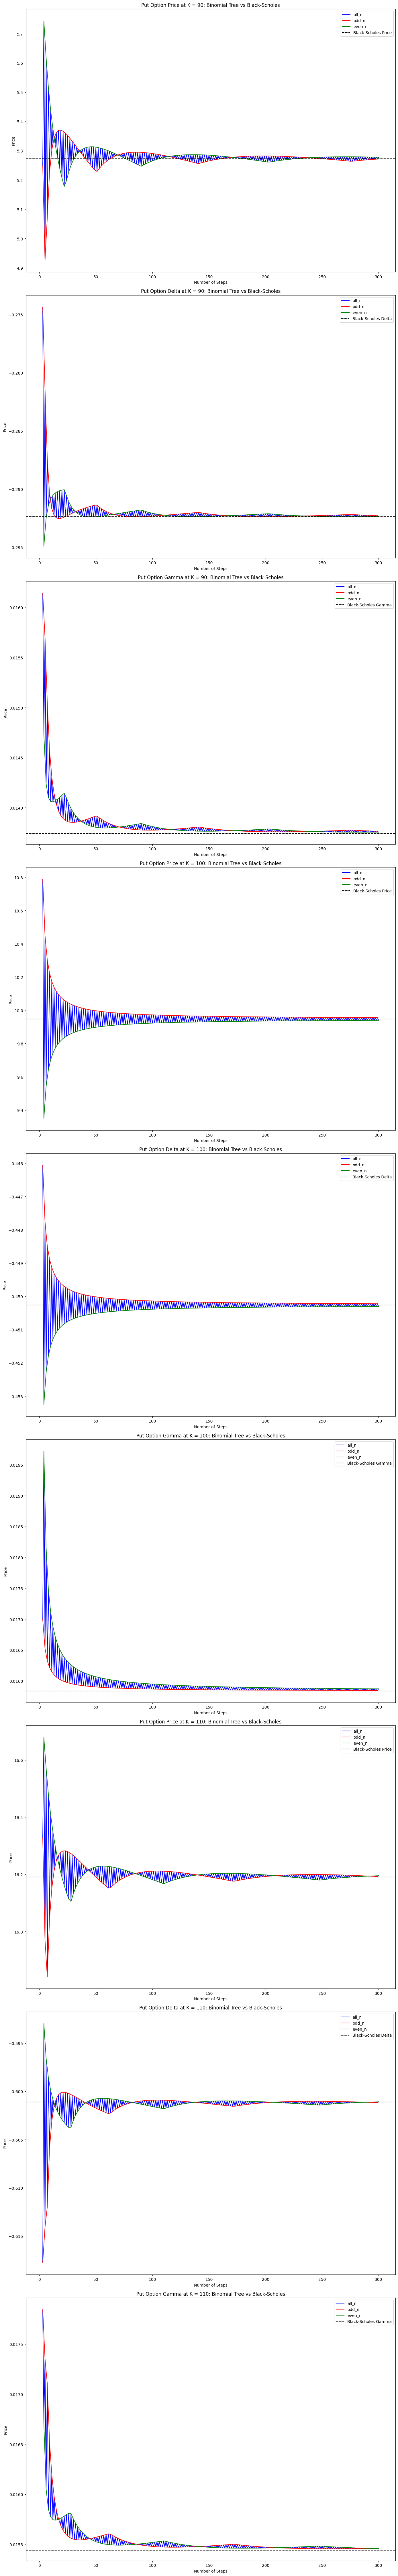

In [73]:
plot_binomial(S0, Ks, T, r, sigma, n_steps, False, True) # Put Option

Comment the obtained results: <br>
The price/delta/gamma is oscillating between even and odd numbers of steps. <br>
With an even number of steps, the model can symmetrically balance the up and down movements (e.g., two up movements can be exactly offset by two down movements).  An odd number of steps introduces an asymmetry because there cannot be an equal number of up and down movements. This can lead to a slight bias in the price paths that reach the terminal nodes, as there will always be one extra move in either the up or down direction. This asymmetry can cause the option price to oscillate as the number of steps changes from odd to even, reflecting the additional up or down movement's impact on the option's terminal payoffs.

#Lecture 2: Exercise 5

In [74]:
def trinomial_tree(S0, K, T, r, sigma, n, lam, isCall = True, isEuropean = True):
    sign_ = 1 if isCall else -1
    dt = T / n
    u = np.exp(lam * sigma * np.sqrt(dt))
    d = np.exp(-lam * sigma * np.sqrt(dt))
    m = 1.0
    pu = 1/(2*lam**2) + (r - 0.5*sigma**2)/(2*lam*sigma) * np.sqrt(dt)
    pd = 1/(2*lam**2) - (r - 0.5*sigma**2)/(2*lam*sigma) * np.sqrt(dt)
    pm = 1 - pu - pd
    df = np.exp(-r * dt)

    # Initialize the end nodes of the tree with option values
    values = np.zeros((2*n+1, n+1))
    for i in range(2*n+1):
        S = S0 * (u**(max(i-n, 0))) * (d**(max(n-i, 0)))
        values[i, n] = max(sign_*(S - K), 0)

    # Backward induction for option value
    for j in range(n-1, -1, -1):
        for i in range(0, 2*j+1):
            p = df * (pu * values[i+2, j+1] + pm * values[i+1, j+1] + pd * values[i, j+1])
            if isEuropean:
                values[i, j] = p
            else:
                S = S0 * (u**(max(i-j, 0))) * (d**(max(j-i, 0)))
                exercise_val = max(sign_*(S - K), 0)
                values[i, j] = max(p, exercise_val)

    return values[0, 0]

In [75]:
def plot_trinomial(S0, Ks, T, r, sigma, lams = [1.0, 1.5, 2.0], n_steps = range(3, 301), isCall = True, isEuropean = True):
    option_type = 'Call' if isCall else 'Put'
    fig, ax = plt.subplots(len(Ks), 1, figsize=(14, 10*len(Ks)))

    for i in range(len(Ks)):
        K = Ks[i]
        bs_price, _, _ = black_scholes(S0, K, T, r, sigma, isCall)
        tt_prices = {}
        for lam in lams:
          tt_prices[str(lam)] = []
        for n in tqdm(n_steps):
            for lam in lams:
                tt_price = trinomial_tree(S0, K, T, r, sigma, n, lam, isCall = True, isEuropean = True)
                tt_prices[str(lam)].append(tt_price)

        tt = pd.DataFrame(tt_prices, index = n_steps)

        for lam in lams:
            ax[i].plot(tt.index, tt[str(lam)], label = f'lambda = {lam}')
        l1 = ax[i].axhline(bs_price, color='black',ls='--')
        l1.set_label('Black-Scholes Price')
        ax[i].set_title(f'{option_type} Option Price at K = {K}: Trinomial Tree vs Black-Scholes')
        ax[i].set_xlabel('Number of Steps')
        ax[i].set_ylabel('Price')
        ax[i].legend(loc = 'best')

    plt.tight_layout()
    plt.show()

In [76]:
S0 = 100  # Initial stock price
r = 0.0  # Risk-free rate
sigma = 0.25  # Volatility
T = 1  # Time to maturity
Ks = [90, 100, 110]  # Strike prices
n_steps = range(3, 301)  # Using steps from 1 to 300
lams = np.linspace(1.0, 2.0, 5)

100%|██████████| 298/298 [01:04<00:00,  4.60it/s]


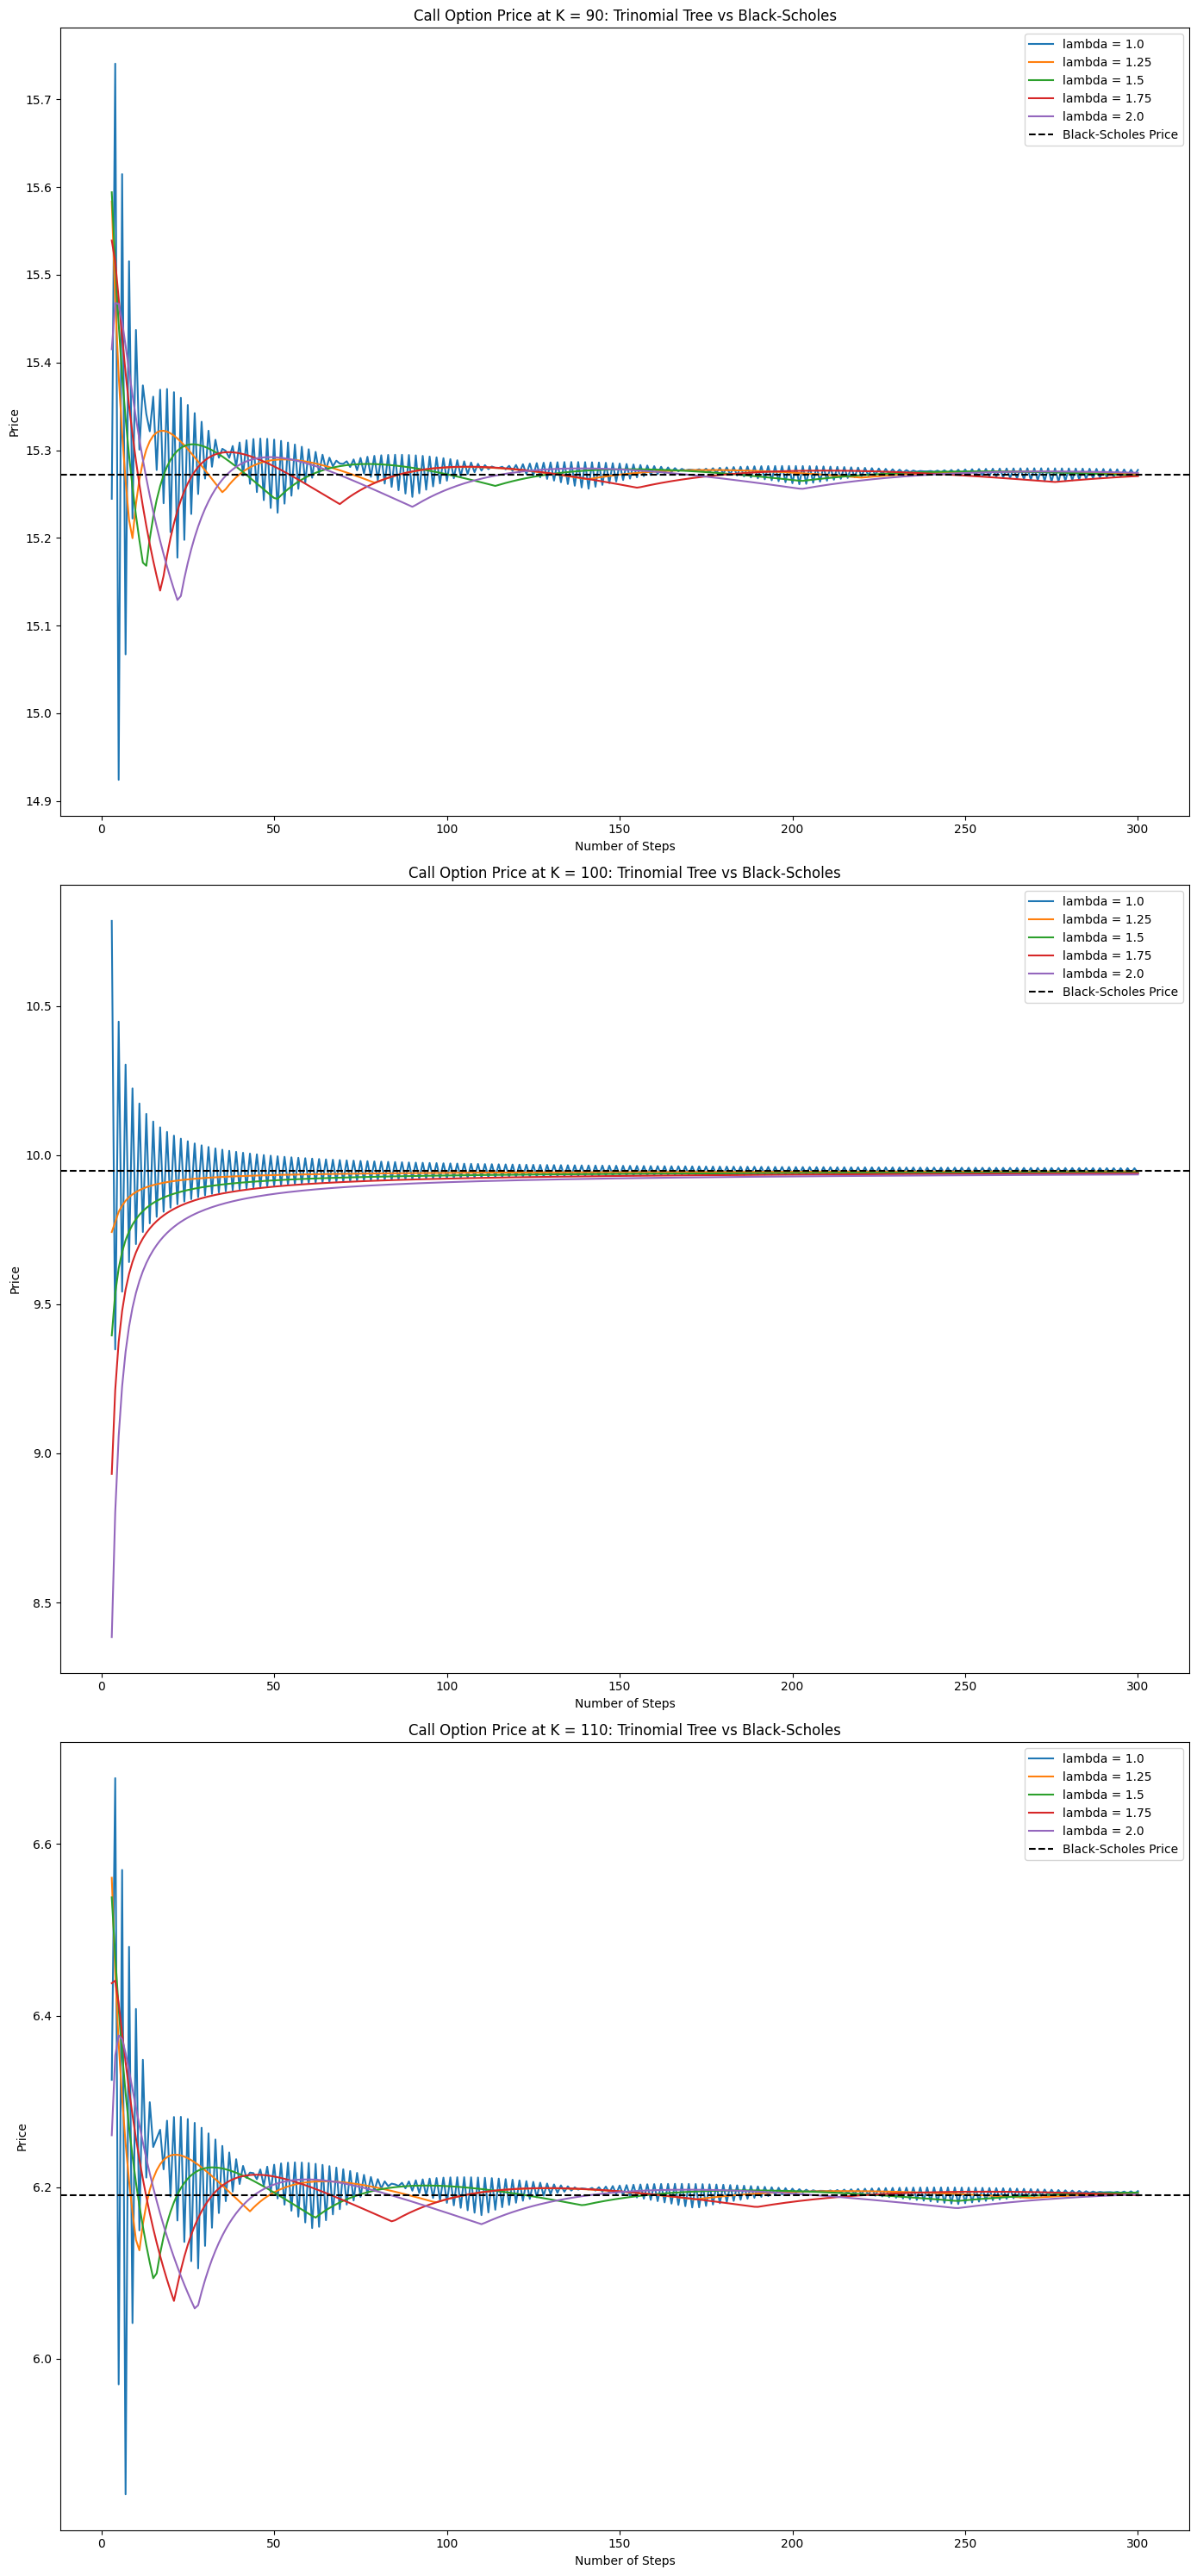

In [77]:
plot_trinomial(S0, Ks, T, r, sigma, lams, n_steps, True, True)

The $\lambda$ is optimal when it is very close to 1 but equal to 1

100%|██████████| 298/298 [00:42<00:00,  6.96it/s]


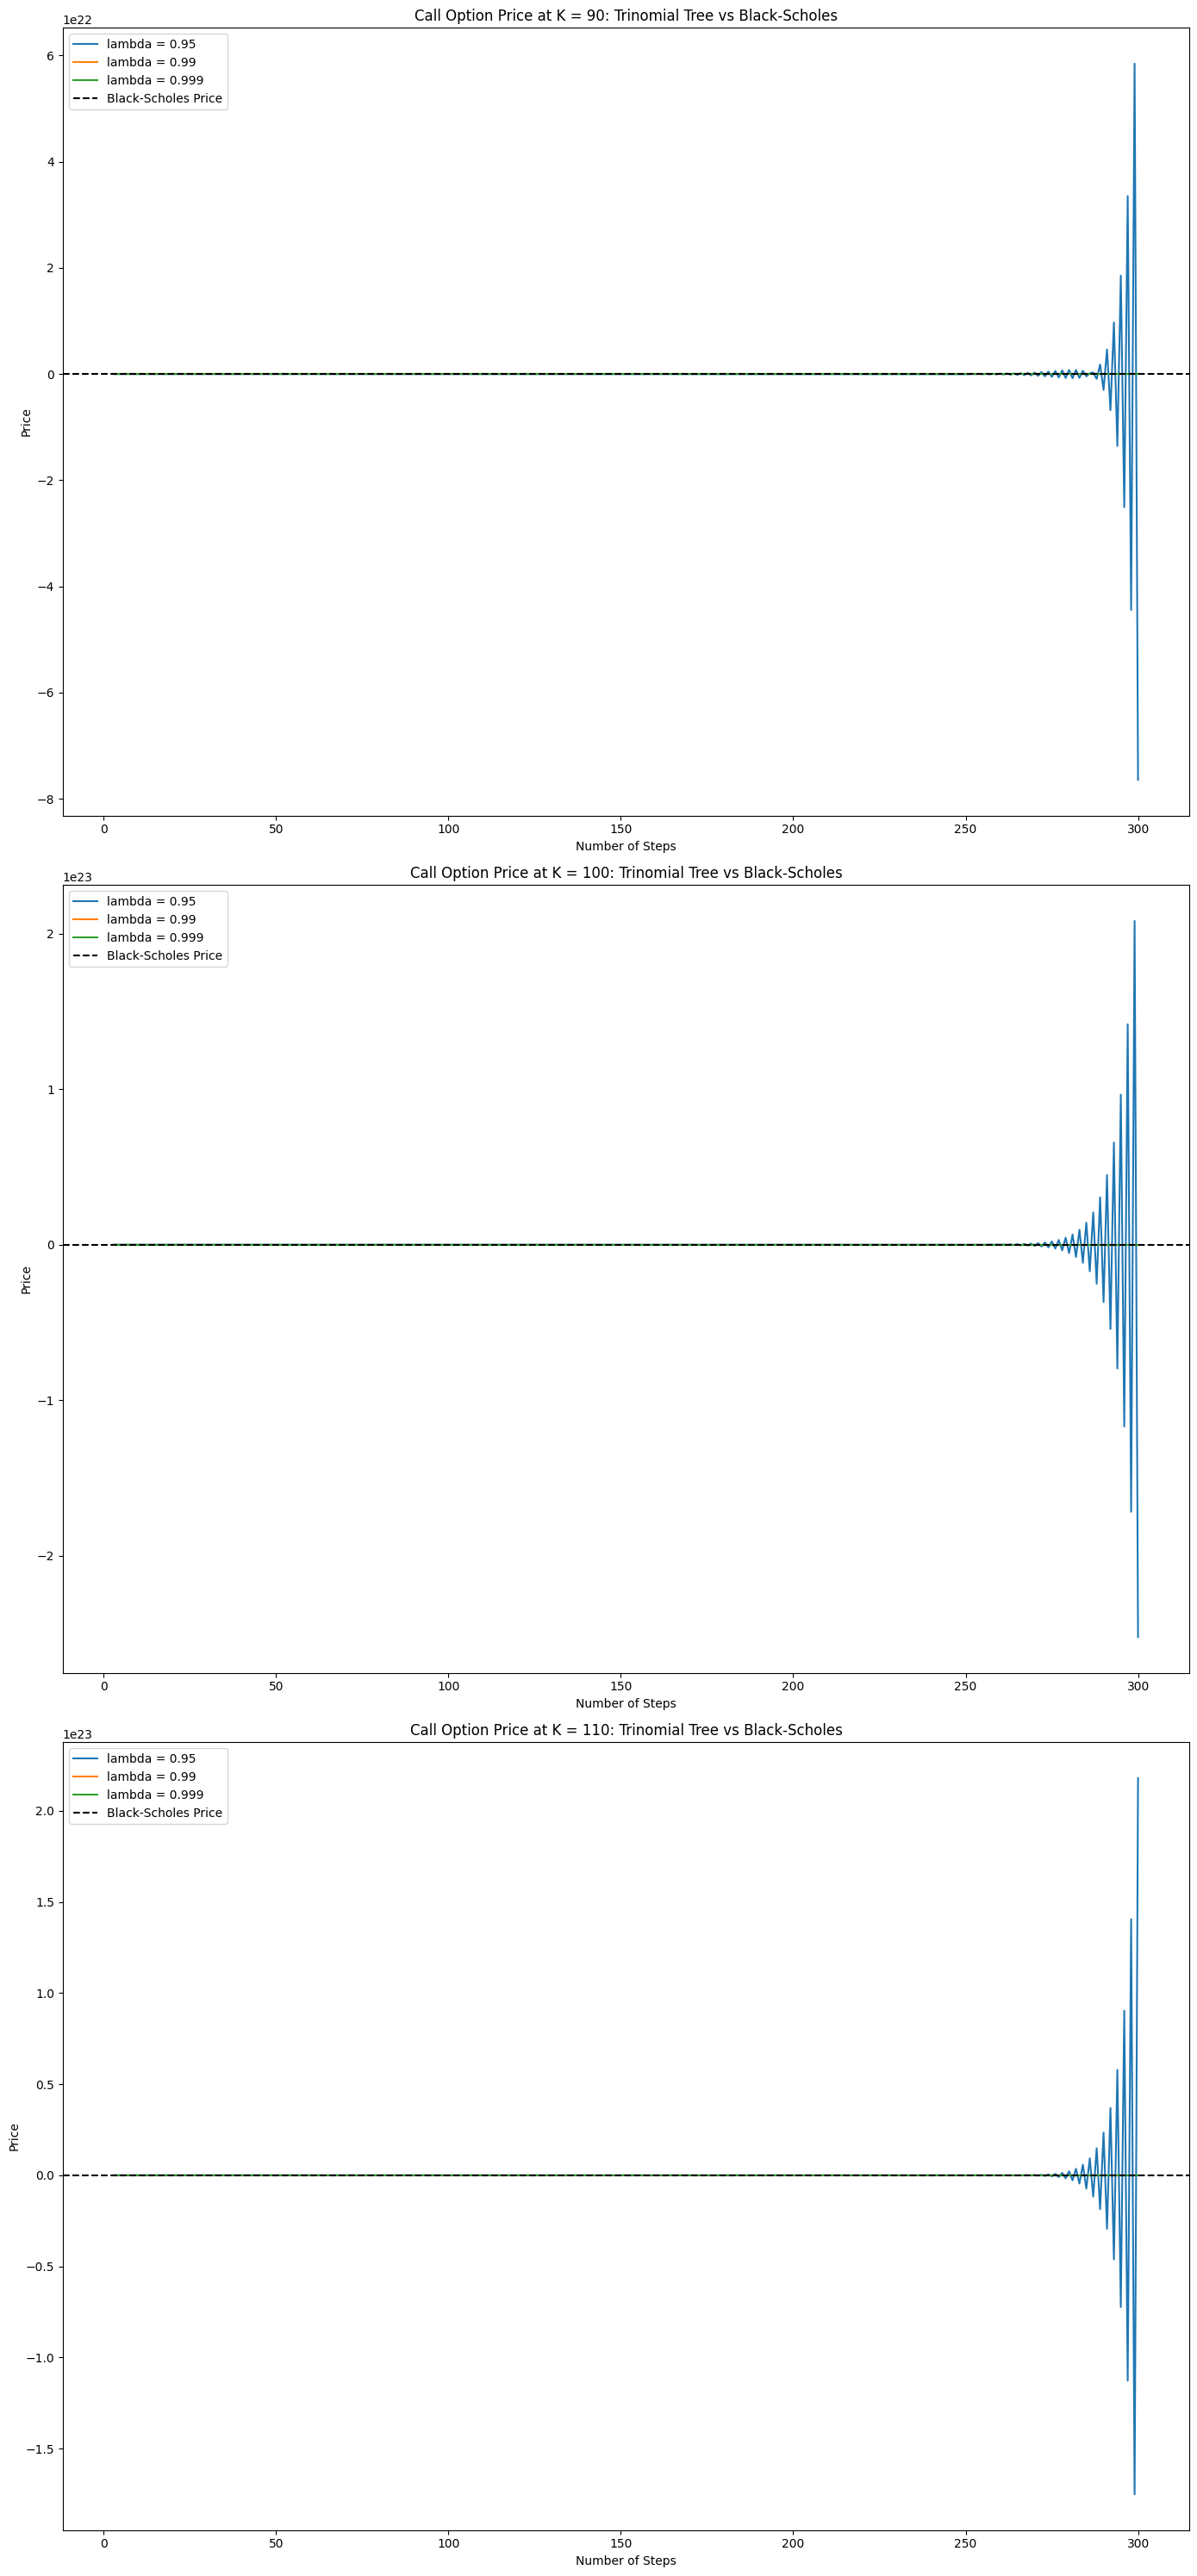

In [78]:
plot_trinomial(S0, Ks, T, r, sigma, [0.95, 0.99, 0.999], n_steps, True, True)

When $\lambda$ is less than 1, the price does not converge.

#Lecture 2: Exercise 6

In [79]:
S0 = 100  # Initial stock price
r = 0.0  # Risk-free rate
sigma = 0.25  # Volatility
T = 1  # Time to maturity
Ks = [80, 100, 110]  # Strike prices
n_steps = range(3, 301)  # Using steps from 1 to 300
lams = np.linspace(1.0, 2.0, 5)

In [80]:
def plot_american(S0, Ks, T, r, sigma, lams = [1.0, 1.5, 2.0], n_steps = range(3, 301), isCall = True, isEuropean = False):
    option_type = 'Call' if isCall else 'Put'
    fig, ax = plt.subplots(len(Ks), 1, figsize=(14, 10*len(Ks)))

    for i in range(len(Ks)):
        K = Ks[i]
        bs_price, _, _ = black_scholes(S0, K, T, r, sigma, isCall)
        prices = {}
        prices['bt'] = []
        for lam in lams:
          prices[str(lam)] = []
        for n in tqdm(n_steps):
            bt_price, _, _ = binomial_tree(S0, K, T, r, sigma, n, isCall, isEuropean)
            prices['bt'].append(bt_price)
            for lam in lams:
                price = trinomial_tree(S0, K, T, r, sigma, n, lam, isCall, isEuropean)
                prices[str(lam)].append(price)

        tree = pd.DataFrame(prices, index = n_steps)

        ax[i].plot(tree.index, tree['bt'], label = 'Binomial', color = 'red', alpha = 0.5)
        for lam in lams:
            ax[i].plot(tree.index, tree[str(lam)], label = f'Trinomial: lambda = {lam}', alpha = 0.5)
        l1 = ax[i].axhline(bs_price, color='black',ls='--')
        l1.set_label('Black-Scholes Price')
        ax[i].set_title(f'American {option_type} Option Price at K = {K}: Trinomial Tree vs Binomial')
        ax[i].set_xlabel('Number of Steps')
        ax[i].set_ylabel('Price')
        ax[i].legend(loc = 'best')

    plt.tight_layout()
    plt.show()

100%|██████████| 298/298 [02:16<00:00,  2.18it/s]


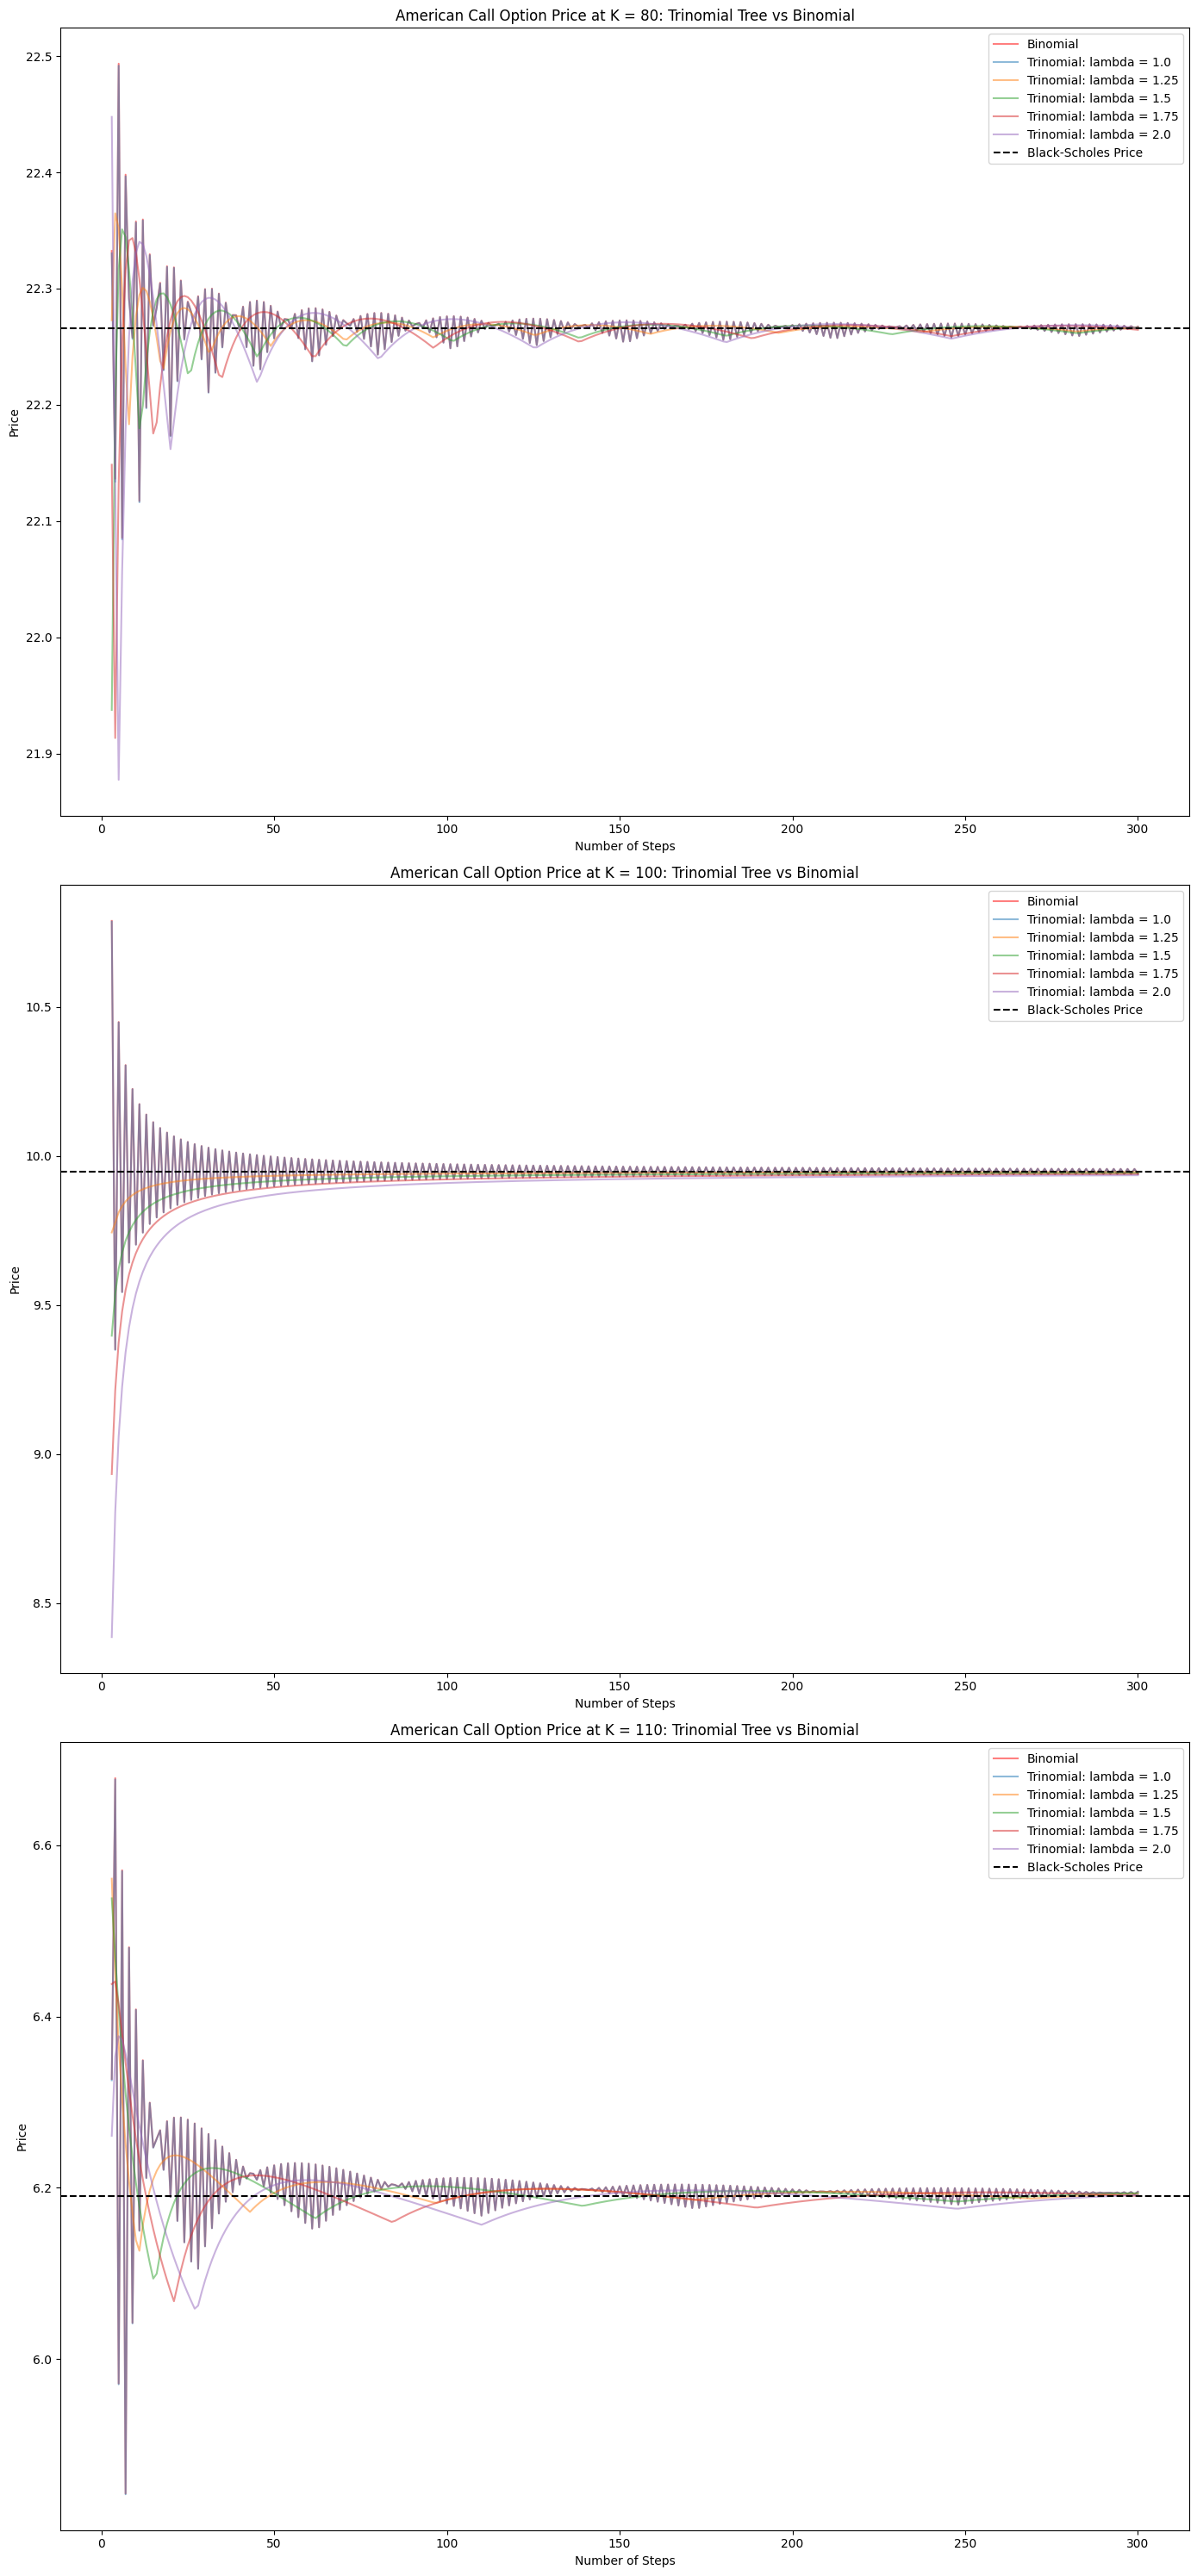

In [81]:
plot_american(S0, Ks, T, r, sigma, lams, n_steps, True, False)

100%|██████████| 298/298 [02:17<00:00,  2.17it/s]


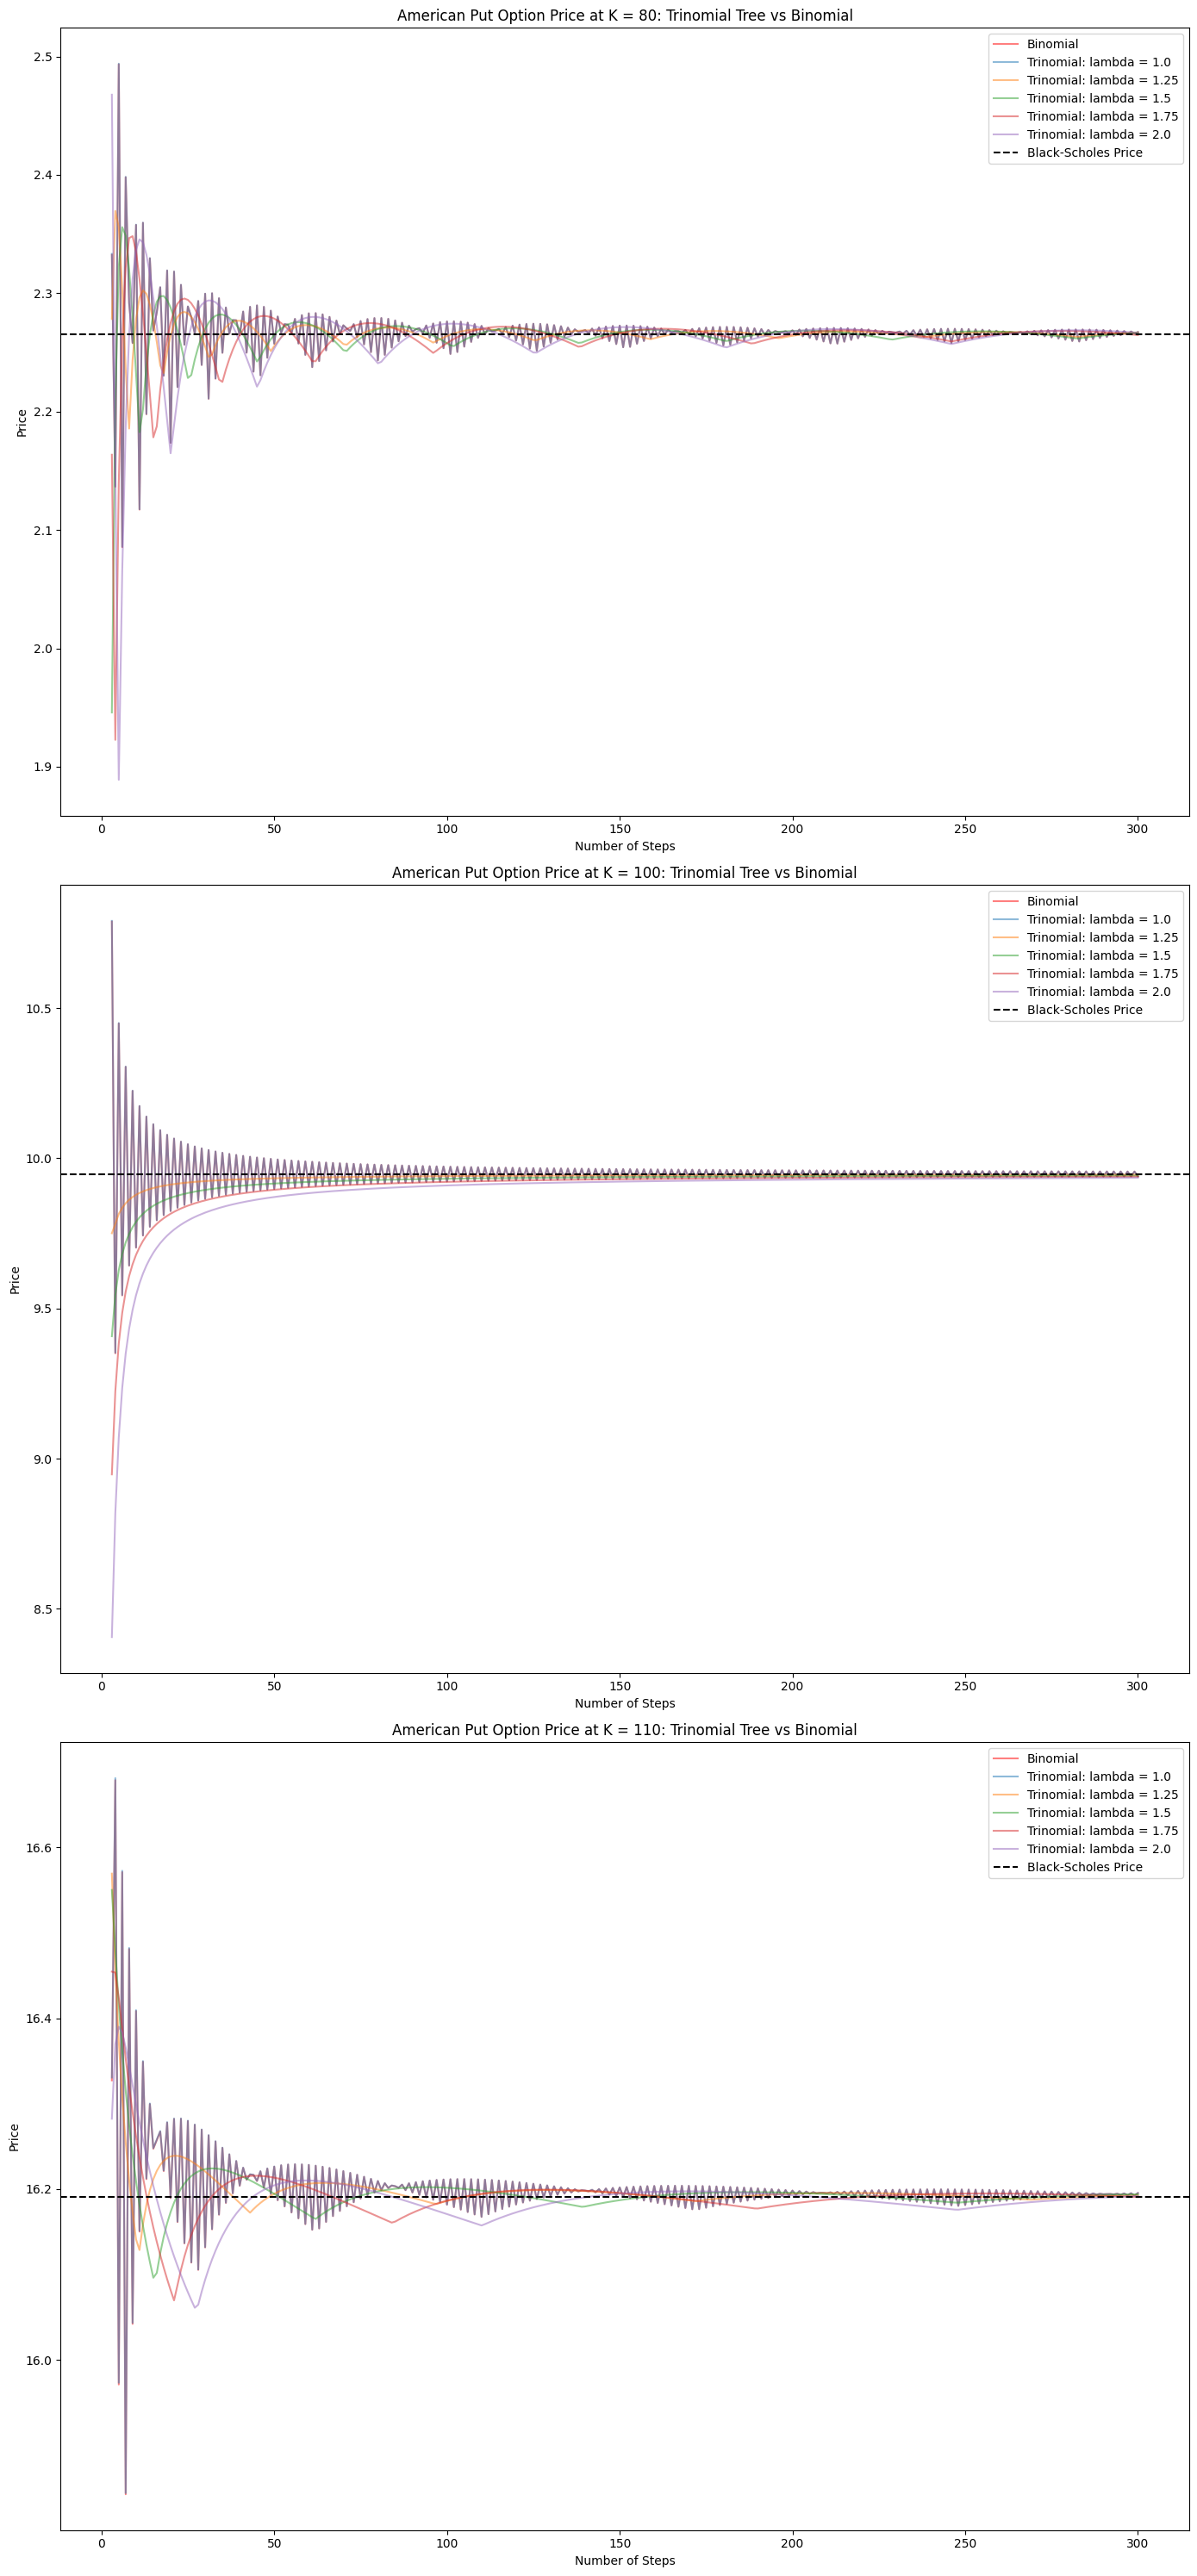

In [82]:
plot_american(S0, Ks, T, r, sigma, lams, n_steps, False, False)

#Written: Lecture 1: Exercise 2

Let $\{t_i\}_{0\leq i \leq n}$ be a partition of $[0, T]$ where $t_0 = 0$, $t_n = T$, $t_i - t_{i-1} = T/n$ for $1\leq i\leq n$.<br>
Since for all $1\leq i \leq n$, $(W_{t_i}- W_{t_{i-1}}) \sim N(0, t_i - t_{i-1}) = N(0, T/n)$, we have <br>
$\mathbb{E}[\sum_{i=1}^{n} (W_{t_i}- W_{t_{i-1}})^2] = \sum_{i=1}^{n} \mathbb{E}[(W_{t_i}- W_{t_{i-1}})^2]
= \sum_{i=1}^{n} Var(W_{t_i}- W_{t_{i-1}}) = n*(T/n) = T$<br>
Note that $(W_{t_i}- W_{t_{i-1}})^2 - (t_i - t_{i-1}) =^d (Z^2 - 1)(t_i - t_{i-1})$ where $Z \sim N(0, 1)$. <br>
Also, $(W_{t_i}- W_{t_{i-1}})^2 - (t_i - t_{i-1})$ are all independent.<br>
Thus, we have
$\mathbb{E}[\left(\sum_{i=1}^{n} (W_{t_i}- W_{t_{i-1}})^2 - \sum_{i=1}^{n}(t_i - t_{i-1}) \right)^2] = \sum_{i=1}^{n} \mathbb{E}[(Z^2-1)^2] (t_i - t_{i-1})^2 = n \mathbb{E}[(\chi^2(1)-1)^2] (T/n)^2 = 2T/n$<br>
Thus, we have $\mathbb{E}[\sum_{i=1}^{n} (W_{t_i}- W_{t_{i-1}})^2] = T$ and $Var(\sum_{i=1}^{n} (W_{t_i}- W_{t_{i-1}})^2) = 2T/n$<br>
As $n\to \infty$, $\lim_{n\to\infty}Var(\sum_{i=1}^{n} (W_{t_i}- W_{t_{i-1}})^2) = 0$ and $\lim_{n\to\infty} \mathbb{E}[\sum_{i=1}^{n} (W_{t_i}- W_{t_{i-1}})^2] = T$.<br>
Therefore, $\langle W, W\rangle_T = T$.